In [1]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from astroquery.gaia import Gaia
from astropy.io import fits
from astropy.table import Table
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import binned_statistic_2d

# git in Practice
Link to my GitHub repository: https://github.com/Kardashevr/ASTR4004_git

1. Commit and push to main: \
    git add .\
    git commit -m "Initial commit: added README and folder structure"\
    git push origin main

2. Make changes in a new branch: \
    git checkout -b Assignments\
    git add .\
    git commit -m "Added files from all assignments"\
    git push origin Assignments

3. Merge branch back into main: \
    git checkout main\
    git pull origin main\
    git merge Assignments\
    git push origin main

# Using ADQL to Search for Bright Stars Around the Open Cluster Ruprecht 147

In [2]:
# ADQL query
# Select all stars within 1 degree of the center of Ruprecht 147 that are brighter than G = 14 in Gaia DR3
# Crossmatch with the 2MASS catalog
query = """
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.phot_g_mean_mag,
       gaia.bp_rp, gaia.parallax, tmass.j_m, tmass.h_m, tmass.ks_m,
       tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin 
    ON xmatch.original_ext_source_id = xjoin.original_psc_source_id
JOIN gaiadr1.tmass_original_valid AS tmass
    ON xjoin.original_psc_source_id = tmass.designation
WHERE 1=CONTAINS(
          POINT('ICRS', gaia.ra, gaia.dec),
          CIRCLE('ICRS', 289.074, -16.323, 1.0))
  AND gaia.phot_g_mean_mag < 14
"""

# Perform query and convert results to pandas DataFrame
job = Gaia.launch_job_async(query)
results = job.get_results()
df = results.to_pandas()

# Display number of stars retrieved
print(f"Number of stars retrieved: {len(df)}")

INFO: Query finished. [astroquery.utils.tap.core]
Number of stars retrieved: 3637


In [3]:
# Identify any stars with bad 2MASS photometry
df_bad_photometry = df[df['ph_qual'] != 'AAA']
print(f"Number of stars with bad 2MASS photometry: {len(df_bad_photometry)}")

# Identify any stars with non-positive parallaxes
df_bad_parallax = df[df['parallax'] <= 0]
print(f"Number of stars with non-positive parallaxes: {len(df_bad_parallax)}")

# Apply quality cuts to the DataFrame
df_clean = df[(df['ph_qual'] == 'AAA') & (df['parallax'] > 0)].copy()
print(f"Number of stars after quality cuts: {len(df_clean)}")

Number of stars with bad 2MASS photometry: 79
Number of stars with non-positive parallaxes: 5
Number of stars after quality cuts: 3535


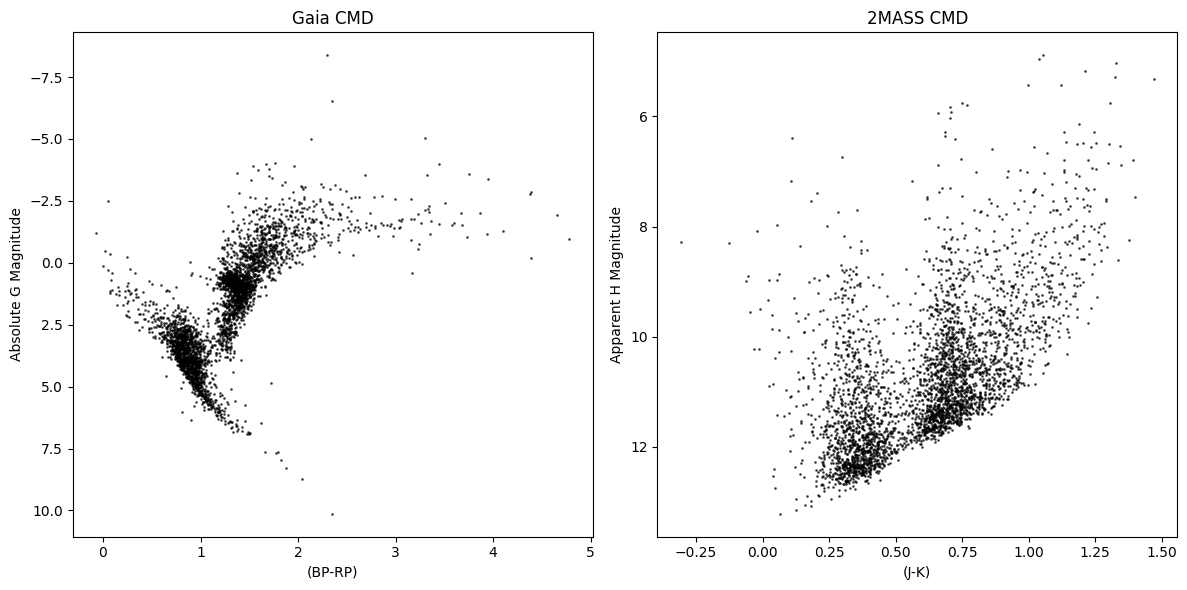

In [4]:
# Calculate distance from parallax
df_clean['d'] = 1000.0 / df_clean['parallax']

# Calculate absolute G magnitude
df_clean['g_m'] = df_clean['phot_g_mean_mag'] - 5 * np.log10(df_clean['d'] / 10)

# Generate figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Gaia CMD
ax1.scatter(df_clean['bp_rp'], df_clean['g_m'], s=1, c='k', alpha=0.6)
ax1.set_xlabel("(BP-RP)")
ax1.set_ylabel("Absolute G Magnitude")
ax1.set_title("Gaia CMD")
ax1.invert_yaxis()

# 2MASS CMD
ax2.scatter(df_clean['j_m'] - df_clean['ks_m'], df_clean['h_m'], s=1, c='k', alpha=0.6)
ax2.set_xlabel("(J-K)")
ax2.set_ylabel("Apparent H Magnitude")
ax2.set_title("2MASS CMD")
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig("figures/cmds_R147.png", dpi=200)
plt.show()

After applying quality cuts to remove stars with poor 2MASS photometry and non-positive parallaxes, a total of 3535 stars remain within the open cluster Ruprecht 147 that are brighter than G = 14 in Gaia DR3. The HERMES spectrograph on the 2dF fibre positioner allows for up to 392 fibres for observations, of which about 360 are available for stars with the remaining allocated for sky/background measurements. There are significantly more stars than the available fibres and around 10 observations are required of observe all targets, thus the proposed observations would be highly efficient purely from a fibre usage perspective.

# The radial metallicity relation in simulated data

In [5]:
# Load data
filename = "data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits"
hdul = fits.open(filename)
fits_data = hdul[1].data
fits_table = Table(fits_data)
data = fits_table.to_pandas()
hdul.close()

Intercept a = 9.128 ± 0.00023
Slope b = -0.034 ± 0.00001


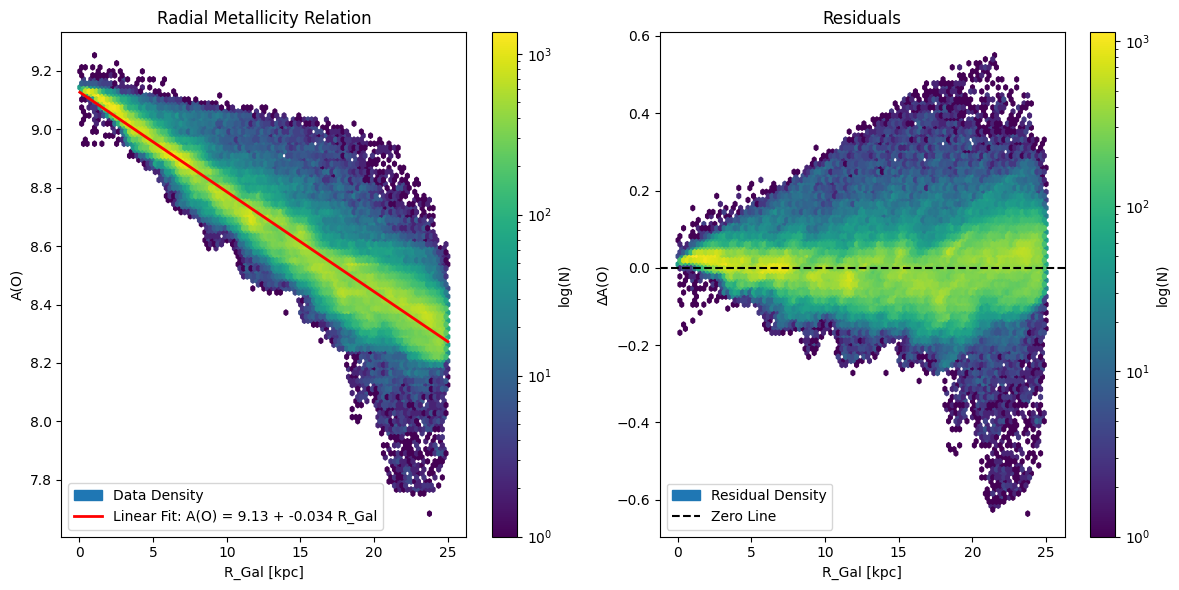

In [6]:
# Compute galactocentric radius
data['Rgal'] = np.sqrt(data['x']**2 + data['y']**2)
data = data.sort_values(by='Rgal')

# Linear model
def linear(R, a, b):
    return a + b*R

# Linear fit
popt, pcov = curve_fit(linear, np.array(data['Rgal']), np.array(data['A_O']), p0=[8.5, -0.05])
a, b = popt
err_a, err_b = np.sqrt(np.diag(pcov))
print(f"Intercept a = {a:.3f} ± {err_a:.5f}")
print(f"Slope b = {b:.3f} ± {err_b:.5f}")

A_O_fit = linear(data["Rgal"], *popt)
residuals = data["A_O"] - A_O_fit

# Generate figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Density scatter with fit
hb1 = ax1.hexbin(data["Rgal"], data["A_O"], gridsize=100, cmap="viridis", bins="log", label='Data Density')
ax1.plot(data["Rgal"], A_O_fit, "r", lw=2, label=f"Linear Fit: A(O) = {a:.2f} + {b:.3f} R_Gal")
ax1.set_xlabel("R_Gal [kpc]")
ax1.set_ylabel("A(O)")
ax1.set_title("Radial Metallicity Relation")
ax1.legend(loc='lower left')
cb = plt.colorbar(hb1, ax=ax1)
cb.set_label("log(N)")

# Residuals
hb2 = ax2.hexbin(data["Rgal"], residuals, gridsize=100, cmap="viridis", bins="log", label='Residual Density')
ax2.axhline(0, color="black", linestyle="--", label='Zero Line')
ax2.set_xlabel("R_Gal [kpc]")
ax2.set_ylabel("ΔA(O)")
ax2.set_title("Residuals")
ax2.legend(loc='lower left')
cb = plt.colorbar(hb2, ax=ax2)
cb.set_label("log(N)")

plt.tight_layout()
plt.savefig("figures/radial_metallicity_fit.png", dpi=200)
plt.show()

In [7]:
# Assess fit quality using RMSE and R²
RMSE_global = np.sqrt(mean_squared_error(data["A_O"], A_O_fit))
R2_global = r2_score(data["A_O"], A_O_fit)
print(f"Global RMSE = {RMSE_global:.4f}")
print(f"Global R² = {R2_global:.4f}")

# Split by region
inner_mask = data["Rgal"] < 15
outer_mask = data["Rgal"] >= 15

RMSE_inner = np.sqrt(mean_squared_error(data.loc[inner_mask, "A_O"], A_O_fit[inner_mask]))
R2_inner = r2_score(data.loc[inner_mask, "A_O"], A_O_fit[inner_mask])

RMSE_outer = np.sqrt(mean_squared_error(data.loc[outer_mask, "A_O"], A_O_fit[outer_mask]))
R2_outer = r2_score(data.loc[outer_mask, "A_O"], A_O_fit[outer_mask])

print("\nBy Region:")
print(f" Inner disc (R < 15 kpc): RMSE = {RMSE_inner:.4f}, R² = {R2_inner:.4f}")
print(f" Outer disc (R ≥ 15 kpc): RMSE = {RMSE_outer:.4f}, R² = {R2_outer:.4f}")

Global RMSE = 0.0726
Global R² = 0.9125

By Region:
 Inner disc (R < 15 kpc): RMSE = 0.0549, R² = 0.8798
 Outer disc (R ≥ 15 kpc): RMSE = 0.0873, R² = 0.4398


The linear model fits reasonably well in the region $(0<R_{Gal}<15)$, with no systematic offsets in the residuals. At larger radii $(R_{Gal}>15)$ the fit becomes worse and shows a large negative residual around $R_{gal} \sim 20$. This is also evident from the RMSE and $R^2$ values computed above, where the fits goodness at lower radii is significantly better than those at higher radii.

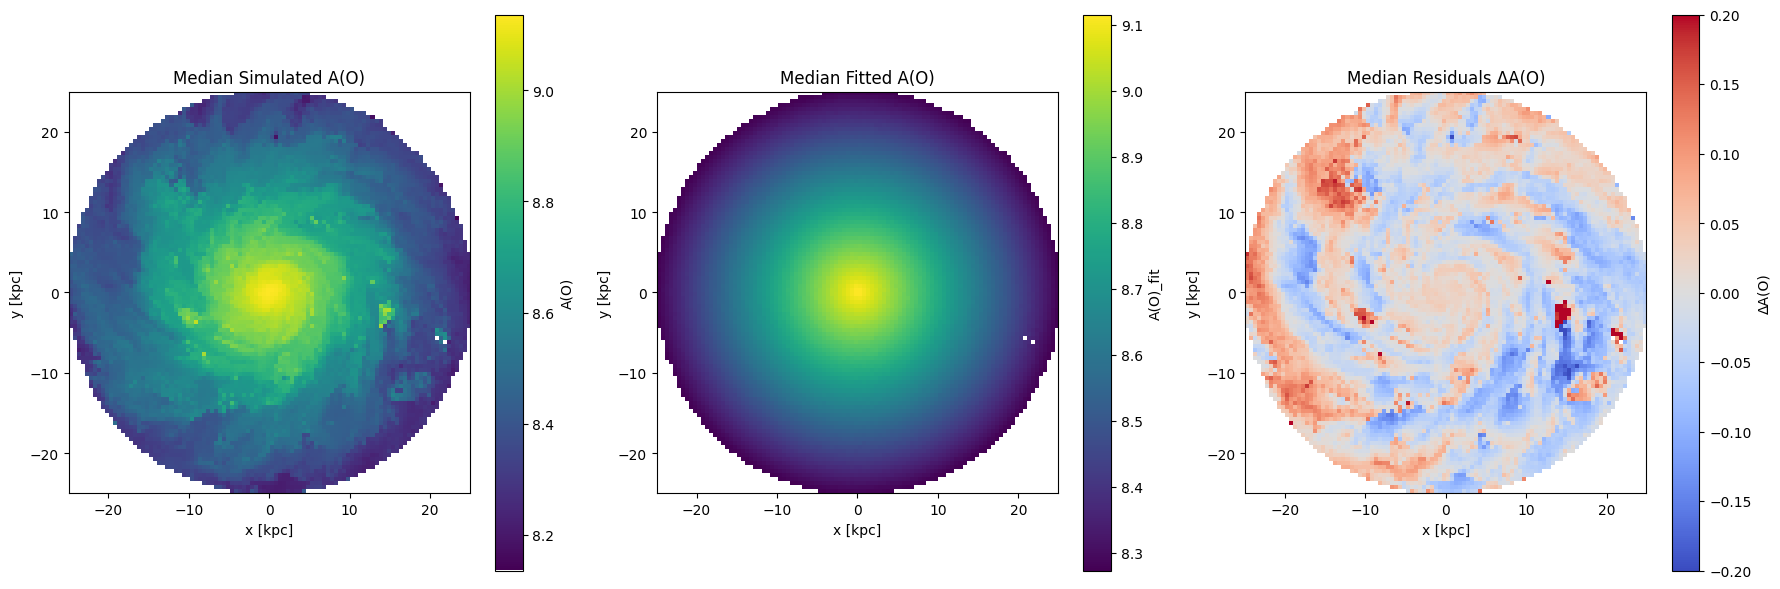

In [8]:
# Define bins for x and y
nbins = 100
x_edges = np.linspace(data["x"].min(), data["x"].max(), nbins+1)
y_edges = np.linspace(data["y"].min(), data["y"].max(), nbins+1)

# Median simulated A(O)
stat_AO, _, _, _ = binned_statistic_2d(
    data["x"], data["y"], data["A_O"],
    statistic="median", bins=[x_edges, y_edges]
)

# Median fitted A(O)
stat_fit, _, _, _ = binned_statistic_2d(
    data["x"], data["y"], A_O_fit,
    statistic="median", bins=[x_edges, y_edges]
)

# Median residuals ΔA(O)
stat_resid, _, _, _ = binned_statistic_2d(
    data["x"], data["y"], residuals,
    statistic="median", bins=[x_edges, y_edges]
)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18,6))

im0 = axes[0].imshow(stat_AO.T, origin="lower", 
                     extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                     cmap="viridis", aspect="equal")
axes[0].set_title("Median Simulated A(O)")
axes[0].set_xlabel("x [kpc]")
axes[0].set_ylabel("y [kpc]")
plt.colorbar(im0, ax=axes[0], label="A(O)")

im1 = axes[1].imshow(stat_fit.T, origin="lower", 
                     extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                     cmap="viridis", aspect="equal")
axes[1].set_title("Median Fitted A(O)")
axes[1].set_xlabel("x [kpc]")
axes[1].set_ylabel("y [kpc]")
plt.colorbar(im1, ax=axes[1], label="A(O)_fit")

im2 = axes[2].imshow(stat_resid.T, origin="lower", 
                     extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                     cmap="coolwarm", aspect="equal", vmin=-0.2, vmax=0.2)
axes[2].set_title("Median Residuals ΔA(O)")
axes[2].set_xlabel("x [kpc]")
axes[2].set_ylabel("y [kpc]")
plt.colorbar(im2, ax=axes[2], label="ΔA(O)")

plt.tight_layout()
plt.savefig("figures/xy_metallicity_maps.png", dpi=200)
plt.show()

The chosen bin size is 100*100, this is fine enough to capture any structure and details without producing too many empty bins. With fewer bins, small scale structure would be smoothened out resulting in missing information. With more bins, there will be too many bins with no data at all and become more vulnerable to noise values.

The residual map reveals that deviations from the linear metallicity model are not random but with a clear spiral pattern, with residuals aligned with spiral arms, likely reflecting an increase of metallicity by nearby star feedback. Thus while the linear model captures the global radial trend, it fails to account for variations driven by spiral structure that more realistic models should include.

All figures and files for this assignment are uploaded to my github.